<a href="https://colab.research.google.com/github/dyhayy/Bank_Marketing/blob/main/fix(%3F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Library yang dibutuhkan
import yfinance as yf
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.arima.model import ARIMA

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dropout,Dense

In [2]:
#download datset ticker untuk saham Bank BCA dari yahoo finance
df = yf.download('BBCA.JK', start='2008-05-05', end='2024-05-05')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-05-05,630.0,640.0,625.0,630.0,469.204803,105005000
2008-05-06,635.0,650.0,625.0,630.0,469.204803,119735000
2008-05-07,630.0,635.0,620.0,635.0,472.928558,42477500
2008-05-08,630.0,645.0,625.0,635.0,472.928558,102915000
2008-05-09,635.0,640.0,625.0,630.0,469.204803,31062500
...,...,...,...,...,...,...
2024-04-26,9700.0,9825.0,9625.0,9625.0,9625.000000,100932900
2024-04-29,9525.0,9850.0,9525.0,9800.0,9800.000000,90063500
2024-04-30,10050.0,10050.0,9800.0,9800.0,9800.000000,109623000


In [3]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3944 entries, 2008-05-05 to 2024-05-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3944 non-null   float64
 1   High       3944 non-null   float64
 2   Low        3944 non-null   float64
 3   Close      3944 non-null   float64
 4   Adj Close  3944 non-null   float64
 5   Volume     3944 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 215.7 KB


In [5]:
#mengecek missing value
df.isnull().values.any()

False

In [6]:
# Asumsi 'df' adalah dfFrame dengan kolom 'Open', 'High', 'Low', 'Close', 'Volume', dan indeks tanggal
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Harga Saham (OHLC)", "Volume Perdagangan"))

# Menambahkan trace OHLC
fig.add_trace(go.Ohlc(x=df.index,
                      open=df['Open'],
                      high=df['High'],
                      low=df['Low'],
                      close=df['Close'],
                      name='Harga'), row=1, col=1)

# Menambahkan trace Volume
fig.add_trace(go.Scatter(x=df.index, y=df['Volume'], name='Volume'), row=2, col=1)

# Memperbarui layout untuk menyembunyikan range slider pada sumbu x
fig.update(layout_xaxis_rangeslider_visible=False)

# Memperbarui layout untuk menambahkan judul utama
fig.update_layout(title_text="Analisis Saham dan Volume Perdagangan")

# Menampilkan figure
fig.show()

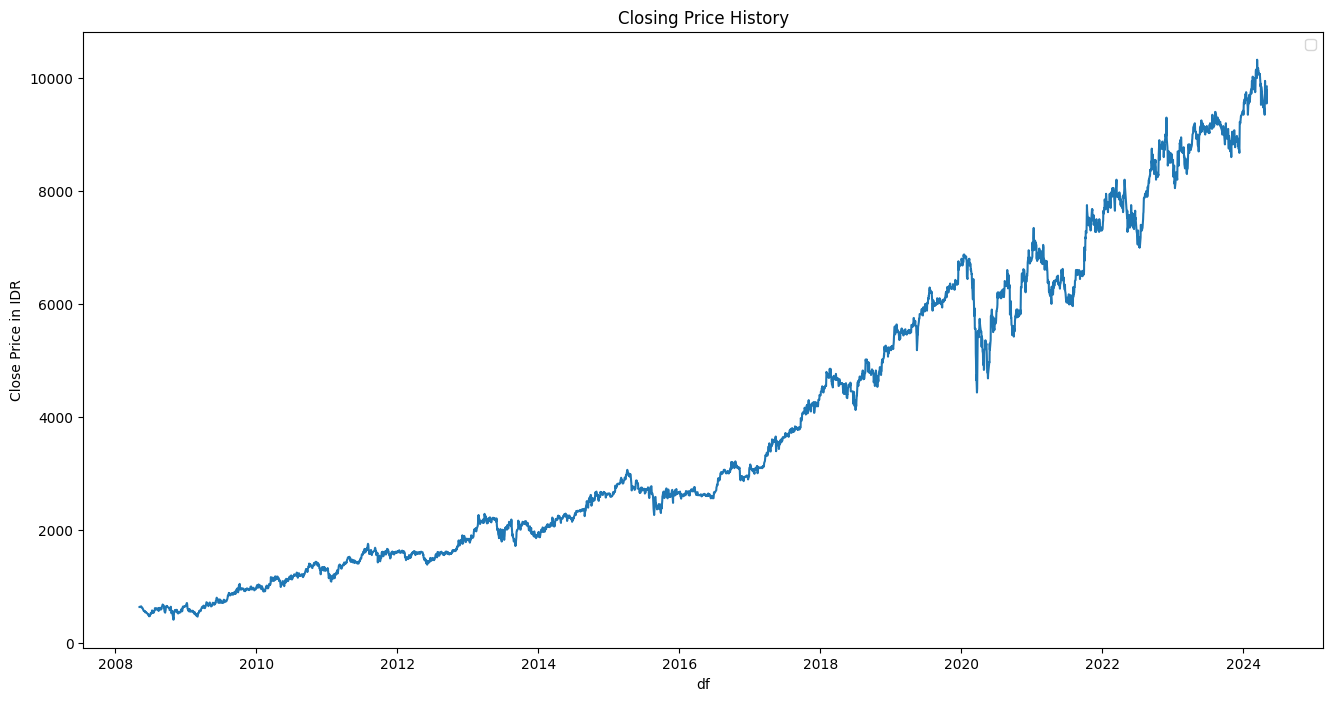

In [7]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(df['Close'])
plt.xlabel("df")
plt.ylabel("Close Price in IDR")
plt.legend()
plt.show()

In [8]:
# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')))

fig.update_layout(
    title='Stock Price History',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Subplots', showlegend=False)

fig.show()
fig_subplots.show()

In [9]:
#Melihat harga penutupan dan harga terendah
df.iloc[:, 2:-1].describe()

,Low,Close,Adj Close
count,3944.000000,3944.000000,3944.000000
mean,3855.394270,3892.532961,3524.165506
std,2658.719173,2678.600676,2617.614638
min,400.000000,405.000000,309.109131
25%,1580.000000,1600.000000,1311.991333
50%,2820.000000,2857.500000,2437.900635
75%,6021.250000,6081.250000,5571.796875
max,10150.000000,10325.000000,10092.431641


## df Scaling

In [10]:
#Memilih Harga Penutupan (Closing Price) dan mengkonvesi menjadi aray 2D
close_prices = df['Close'].values.reshape(-1, 1)

#Normalisasi df menggunakan Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(close_prices)

In [11]:
# Extract original and scaled close prices
# Calculate statistics
original_stats = pd.Series(df['Close'].values).describe()
scaled_stats = pd.Series(df_scaled.flatten()).describe()

# Print the summary
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)

Original Close Prices Statistics:
count     3944.000000
mean      3892.532961
std       2678.600676
min        405.000000
25%       1600.000000
50%       2857.500000
75%       6081.250000
max      10325.000000
dtype: float64

Scaled Close Prices Statistics:
count    3944.000000
mean        0.351566
std         0.270020
min         0.000000
25%         0.120464
50%         0.247228
75%         0.572203
max         1.000000
dtype: float64


df sudah berada pada rentang 0-1

In [12]:
# Data preparation
def create_df(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        lag_values = data[i:(i + time_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + time_steps, 0]]]))
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [13]:
time_steps = 120
X, y = create_df(df_scaled, time_steps)

In [14]:
# Splitting into train, test, and validation sets
train_size = int(len(X) * 0.8)
test_size = int(len(X) * 0.1)
validation_size = len(X) - train_size - test_size

X_train, X_test, X_val = X[:train_size], X[train_size:train_size + test_size], X[train_size + test_size:]
y_train, y_test, y_val = y[:train_size], y[train_size:train_size + test_size], y[train_size + test_size:]

In [15]:
# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_gru = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

#**Hyperparameter Tuning**

In [16]:
#Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

def objective(params, model_type, X_train, y_train, X_val, y_val):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))

    mse = mean_squared_error(y_val_orig, y_pred)
    return mse, history

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_val_lstm, y_val)[0],
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_val_gru, y_val)[0],
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
best_params_gru = space_eval(space, best_gru)

12/12 [==============================] - 2s 88ms/step

12/12 [==============================] - 4s 210ms/step

12/12 [==============================] - 4s 204ms/step

12/12 [==============================] - 2s 55ms/step

12/12 [==============================] - 4s 211ms/step

12/12 [==============================] - 2s 93ms/step

12/12 [==============================] - 2s 52ms/step

12/12 [==============================] - 5s 217ms/step

12/12 [==============================] - 2s 93ms/step

12/12 [==============================] - 4s 239ms/step

12/12 [==============================] - 4s 212ms/step

12/12 [==============================] - 2s 91ms/step

12/12 [==============================] - 2s 93ms/step

12/12 [==============================] - 4s 223ms/step

12/12 [==============================] - 2s 97ms/step

12/12 [==============================] - 5s 256ms/step

12/12 [==============================] - 2s 57ms/step

12/12 [==============================] - 2s 98ms/step

12

In [18]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_val_gru, y_val), callbacks=[early_stopping])


Epoch 1/50
96/96 - 37s - loss: 0.0133 - val_loss: 0.0037 - 37s/epoch - 386ms/step
Epoch 2/50
96/96 - 28s - loss: 3.0135e-04 - val_loss: 0.0029 - 28s/epoch - 296ms/step
Epoch 3/50
96/96 - 28s - loss: 3.4346e-04 - val_loss: 0.0031 - 28s/epoch - 294ms/step
Epoch 4/50
96/96 - 28s - loss: 2.4630e-04 - val_loss: 0.0023 - 28s/epoch - 295ms/step
Epoch 5/50
96/96 - 28s - loss: 2.3850e-04 - val_loss: 0.0012 - 28s/epoch - 295ms/step
Epoch 6/50
96/96 - 28s - loss: 2.9298e-04 - val_loss: 0.0025 - 28s/epoch - 296ms/step
Epoch 7/50
96/96 - 30s - loss: 2.3023e-04 - val_loss: 0.0013 - 30s/epoch - 317ms/step
Epoch 8/50
96/96 - 29s - loss: 2.0048e-04 - val_loss: 4.2702e-04 - 29s/epoch - 298ms/step
Epoch 9/50
96/96 - 28s - loss: 2.5827e-04 - val_loss: 0.0019 - 28s/epoch - 292ms/step
Epoch 10/50
96/96 - 28s - loss: 2.1481e-04 - val_loss: 0.0012 - 28s/epoch - 294ms/step
Epoch 11/50
96/96 - 28s - loss: 2.5984e-04 - val_loss: 8.1346e-04 - 28s/epoch - 296ms/step
Epoch 12/50
96/96 - 28s - loss: 2.4384e-04 - val

In [19]:
# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)


12/12 [==============================] - 2s 85ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 28622.91160735098
Root Mean Squared Error (RMSE): 169.18307127886933
Mean Absolute Percentage Error (MAPE): 1.9643517931805978
12/12 [==============================] - 3s 164ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 4066.1523011529644
Root Mean Squared Error (RMSE): 63.76638849074773
Mean Absolute Percentage Error (MAPE): 0.7991534816079643


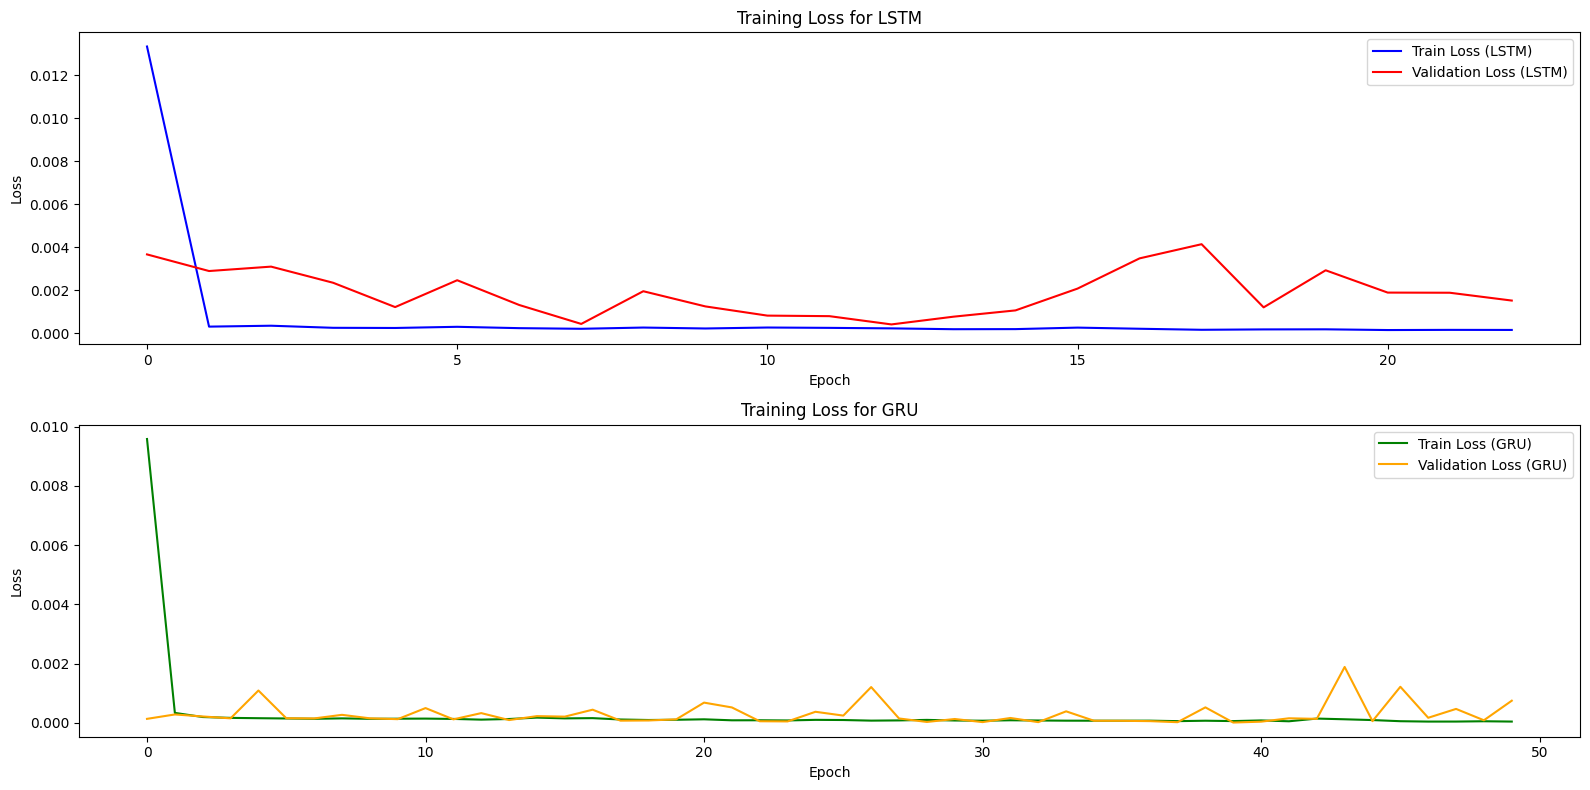

In [20]:
# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))

# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='orange')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (IDR)",
                  template='plotly_dark')

fig.show()

# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
actual_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Actual'])
lstm_predictions = pd.DataFrame(y_pred_lstm, columns=['LSTM Prediction'])
gru_predictions = pd.DataFrame(y_pred_gru, columns=['GRU Prediction'])

# Combining into a single DataFrame
results_df = pd.concat([actual_values, lstm_predictions, gru_predictions], axis=1)
results_df

,Actual,LSTM Prediction,GRU Prediction
0,6800.0,6956.657227,6846.853516
1,6720.0,6952.860840,6816.947754
2,6605.0,6936.549316,6718.950684
3,6705.0,6915.054688,6749.145508
4,6765.0,6895.430176,6810.605957
...,...,...,...
377,8475.0,8469.397461,8536.802734
378,8475.0,8477.591797,8517.198242
379,8375.0,8474.319336,8452.911133
380,8425.0,8464.494141,8454.329102


In [23]:
# Function to make future predictions using GRU model
def predict_future(model, data, n_steps, n_days):
    predictions = []
    current_input = data[-n_steps:].reshape((1, n_steps, 1))

    for _ in range(n_days):
        next_prediction = model.predict(current_input)
        predictions.append(next_prediction[0, 0])
        current_input = np.append(current_input[:, 1:, :], next_prediction.reshape((1, 1, 1)), axis=1)

    return np.array(predictions)

# Assuming the final GRU model and scaler are already defined and trained
n_days = 30  # Number of days to predict
future_predictions = predict_future(final_model_gru, df_scaled, time_steps , n_days)

# Inverse transform the predictions to get actual stock prices
future_predictions_actual = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Creating a DataFrame for the future predictions with numbering
future_predictions_df = pd.DataFrame({'GRU Prediction': future_predictions_actual.flatten()},
                                     index=np.arange(1, len(future_predictions_actual) + 1))

# Display the table
future_predictions_df

1/1 [==============================] - 0s 41ms/step


,GRU Prediction
1,9732.650391
2,9735.997070
3,9692.584961
4,9669.569336
5,9646.513672
6,9619.456055
7,9595.585938
8,9571.642578
9,9546.301758
10,9521.118164


1. 6 may : 9732.650391
2. 7 may : 9735.997070
3. 8 may : 9692.584961
4. 13 may :9669.569336
5. 14 may : 9646.513672
6. 15 may : 9619.456055
7. 16 may :	9595.585938
8. 17 may :	9571.642578
9. 20 may : 9546.301758
10. 21 may : 9521.118164
11. 22 may : 9495.774414
12. 27 may : 9469.896484
13. 28 may : 9443.769531
14. 29 may : 9417.426758
15. 30 may : 9390.792969
16. 31 may : 9363.936523
17. 3 juni : 9336.900391
18. 4 juni : 9309.703125
19. 5 juni : 9282.401367
20. 6 juni : 9255.029297
21. 7	juni : 9227.617188
22. 10 juni : 9200.207031
23. 11 juni : 9172.843750
24. 12 juni : 9145.563477
25. 13 juni : 9118.409180
26. 14 juni : 9091.415039
27. 19 juni : 9064.615234
28. 20 juni : 9038.056641
29. 21 juni :	9011.766602
30. 24 juni : 8985.789062

In [39]:
# Generate index for the future dates (numbering)
future_dates = np.arange(len(df_scaled), len(df_scaled) + n_days)

# Extract dates for actual data
actual_dates = pd.date_range(start='2008-05-05', periods=len(df_scaled), freq='B')
# Plot using Plotly
fig = go.Figure()

# Add actual stock prices trace
fig.add_trace(go.Scatter(x=actual_dates,
                         y=scaler.inverse_transform(df_scaled.flatten().reshape(-1, 1)).flatten(),
                         mode='lines',
                         name='Actual Stock Prices',
                         line=dict(color='blue')))

# Add future predictions trace
fig.add_trace(go.Scatter(x=pd.date_range(start=actual_dates[-1], periods=n_days + 1, freq='B')[1:],
                         y=future_predictions_actual.flatten(),
                         mode='lines',
                         name='Future Predictions (GRU)',
                         line=dict(color='orange', dash='dot')))

fig.update_layout(title='Stock Price Prediction for Next Month (GRU)',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (IDR)',
                  template='plotly_dark',
                  legend=dict(x=0.5, y=1, xanchor='left', yanchor='bottom', orientation='h'))

fig.show()